In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from tinyshift.outlier import HBOS, SPAD, PCAReconstructionError
from tinyshift.tracker import AnomalyTracker
from sklearn.model_selection import train_test_split
from tinyshift.stats import hampel_filter
import plotly.express as px

In [2]:

weights = [0.2, 0.8]

X, y = make_classification(
    n_samples=100000, 
    n_features=20, 
    n_informative=2,      
    weights=weights, 
    random_state=42,
    n_redundant=2)

num_samples = X.shape[0]

categorical_col1 = np.random.choice(['A', 'B', 'C'], size=num_samples)
categorical_col2 = np.random.choice(['X', 'Y', 'Z'], size=num_samples)

df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])
df['cat1'] = categorical_col1
df['cat2'] = categorical_col2
df["cat1"] = df["cat1"].astype("category").cat.rename_categories({"A": 0, "B": 1, "C": 2})
df["cat2"] = df["cat2"].astype("category").cat.rename_categories({"Z": 0, "Y": 1, "X": 2})

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

## HBOS

In [3]:
hbos = HBOS()
hbos.fit(df_train, nbins="fd", dynamic_bins=True)

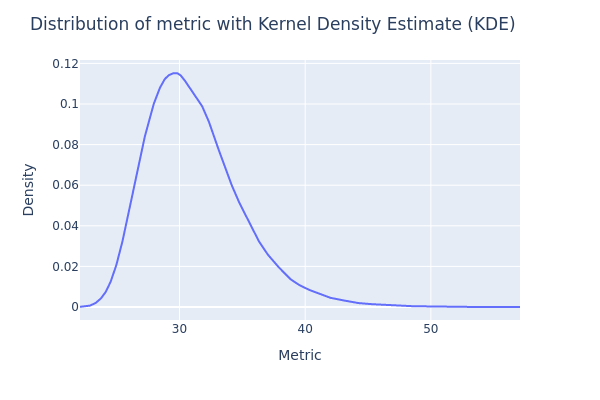

In [5]:
tracker = AnomalyTracker(hbos, drift_limit=("quantile", None, 0.99))
tracker.plot.kde(fig_type="png")

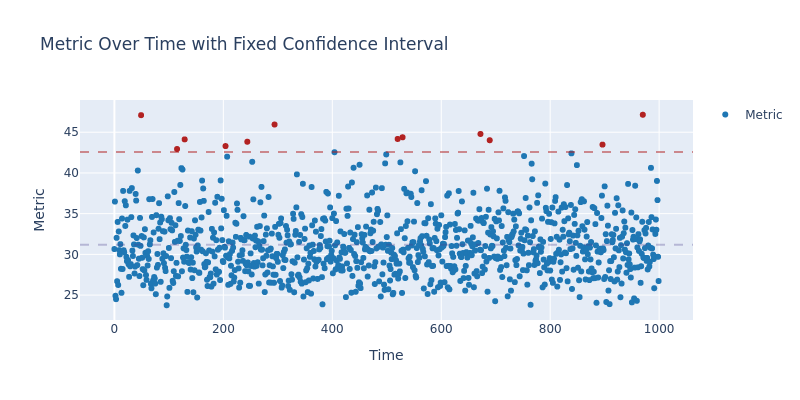

In [6]:
tracker.plot.scatter(tracker.anomaly_scores[:1000], fig_type="png")

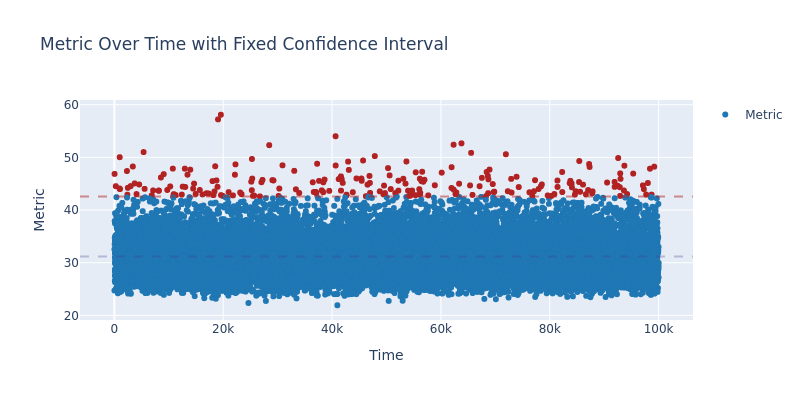

In [7]:
scored = tracker.score(df_test)
tracker.plot.scatter(scored, fig_type="png")

In [8]:
assert np.sum(tracker.predict(df_test)) == np.sum(hbos.predict(df_test))

## SPAD

In [9]:
spad = SPAD()
spad.fit(df_train, nbins="fd", method="mad")

In [10]:
def percentile_threshold(data: pd.DataFrame):
    """Calculates thresholds using the 99th percentiles."""
    lower_limit = np.percentile(data, 1, method="higher")
    upper_limit = None
    return lower_limit, upper_limit

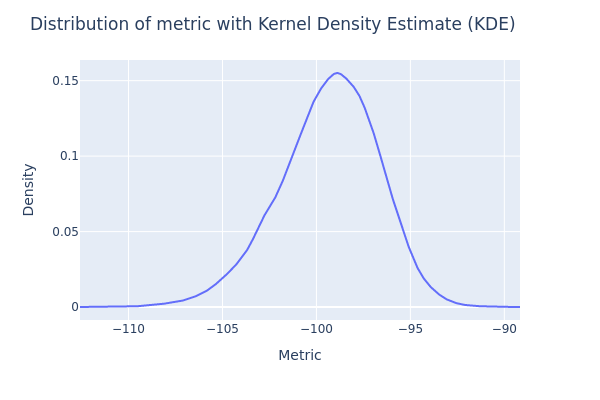

In [11]:
tracker = AnomalyTracker(spad, drift_limit=("quantile", 0.01, None))
tracker.plot.kde(fig_type="png")

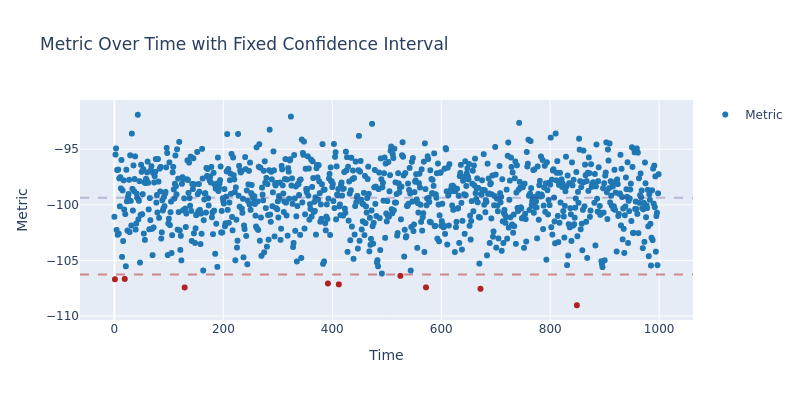

In [12]:
tracker.plot.scatter(tracker.anomaly_scores[:1000], fig_type="png")

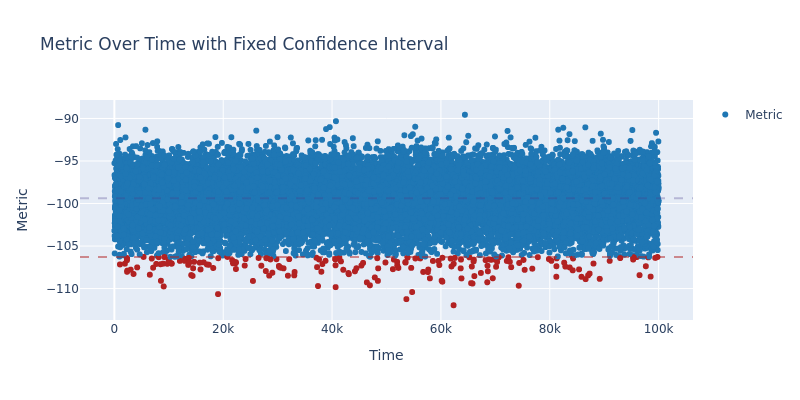

In [13]:
scored = tracker.score(df_test)
tracker.plot.scatter(scored, fig_type="png")

In [14]:
assert np.sum(tracker.predict(df_test)) == np.sum(spad.predict(df_test))

## SPAD+

In [15]:
spad_plus = SPAD(plus=True)
spad_plus.fit(df_train)

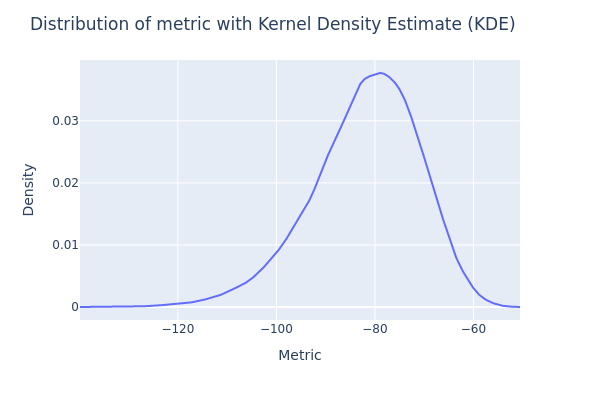

In [16]:
tracker = AnomalyTracker(spad_plus, drift_limit=("quantile", 0.01, None))
tracker.plot.kde(fig_type="png")

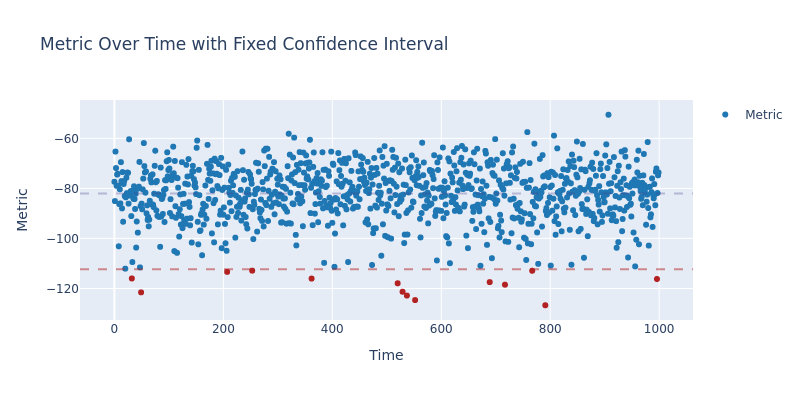

In [17]:
tracker.plot.scatter(tracker.anomaly_scores[:1000], fig_type="png")

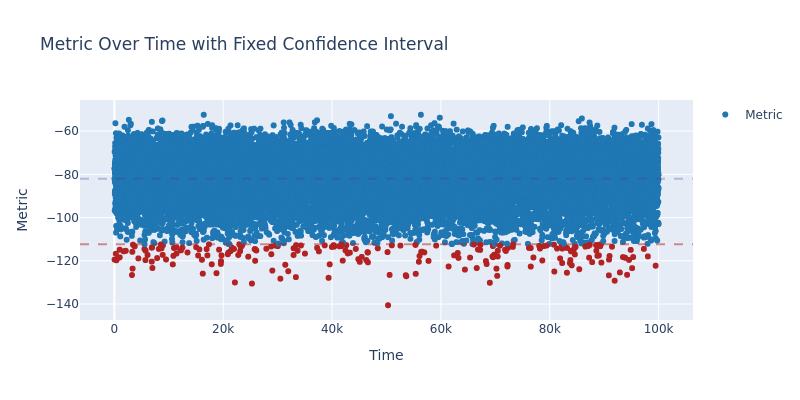

In [18]:
scored = tracker.score(df_test)
tracker.plot.scatter(scored, fig_type="png")

In [19]:
assert np.sum(tracker.predict(df_test)) == np.sum(spad_plus.predict(df_test))

# PCAReconstructionError

In [20]:
model = PCAReconstructionError()
model.fit(df_train.loc[:, ~df_train.columns.isin(['cat1', 'cat2'])])

In [21]:
def percentile_threshold(data: pd.DataFrame):
    """Calculates thresholds using the 99th percentiles."""
    lower_limit = None
    upper_limit = np.percentile(data, 99, method="higher")
    return lower_limit, upper_limit

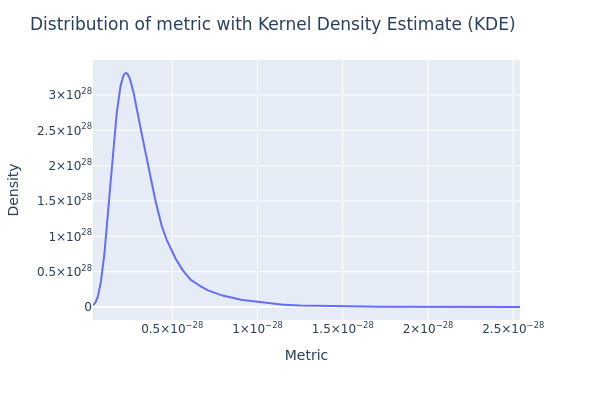

In [22]:
tracker = AnomalyTracker(model, drift_limit=percentile_threshold)
tracker.plot.kde(fig_type="png")

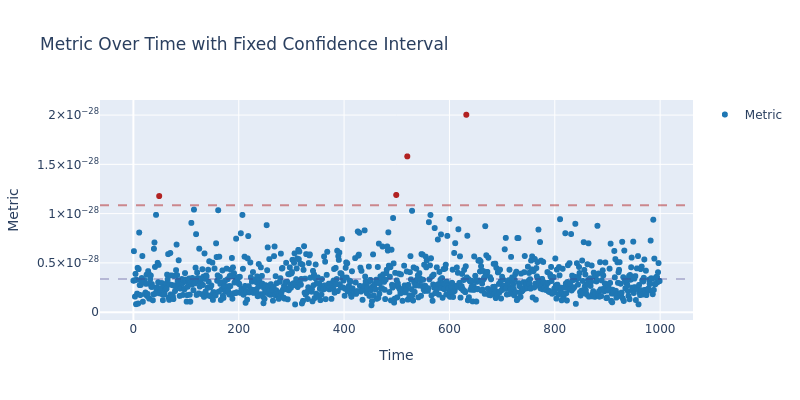

In [23]:
tracker.plot.scatter(tracker.anomaly_scores[:1000], fig_type="png")

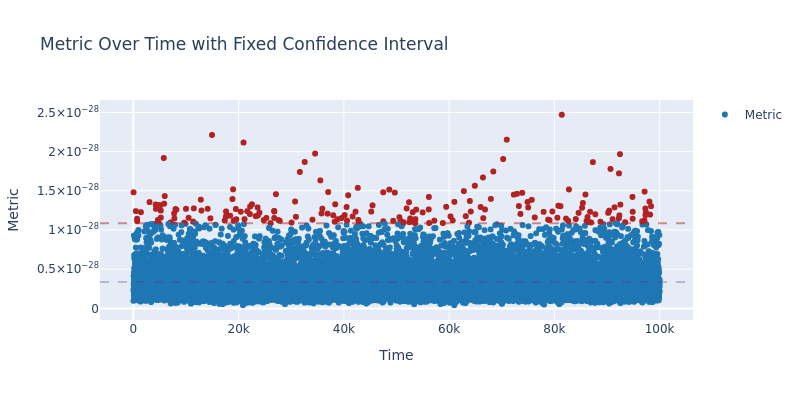

In [24]:
scored = tracker.score(df_test.loc[:, ~df_test.columns.isin(['cat1', 'cat2'])])
tracker.plot.scatter(scored, fig_type="png")

In [25]:
assert np.sum(tracker.predict(df_test.loc[:, ~df_test.columns.isin(['cat1', 'cat2'])])) == np.sum(model.predict(df_test.loc[:, ~df_test.columns.isin(['cat1', 'cat2'])]))

# Hampel Filter

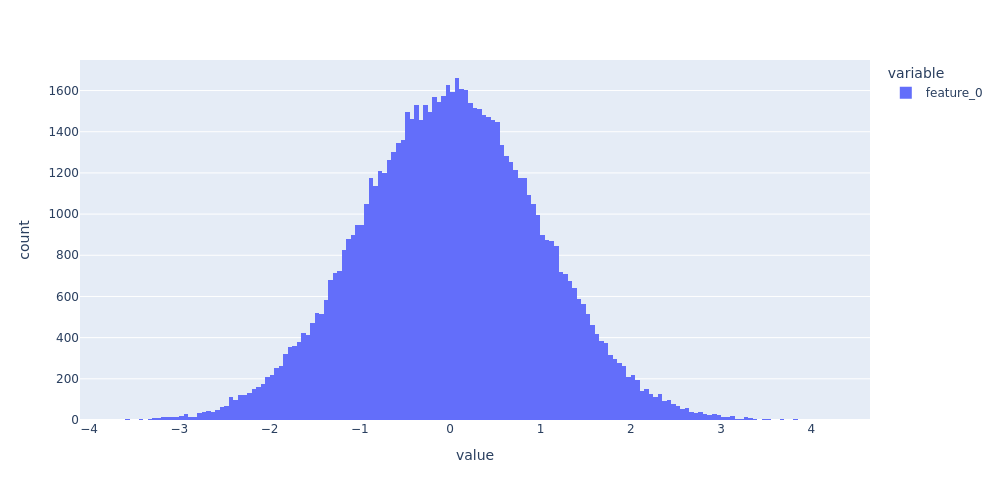

In [26]:
fig = px.histogram(df_train["feature_0"])
fig.show("png", width=1000)

In [27]:
mask = hampel_filter(df_train["feature_0"], rolling_window=31)

In [28]:
df_train[mask]

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,cat1,cat2
61961,-1.779665,1.949351,0.242436,-0.702061,0.177151,-0.678224,0.660179,1.635149,-0.079481,0.491889,...,0.980143,0.411701,-0.344906,0.565714,0.967122,0.750586,0.414963,1.649182,1,0
53814,1.882009,-1.701458,0.272789,-0.611621,0.863591,-1.107353,-1.150314,-1.352669,1.403432,0.557446,...,-0.198219,-0.877925,-0.137618,0.430992,0.775518,-0.121069,-0.995775,-0.193363,0,1
48439,2.017749,-1.178253,-0.887489,-0.251377,3.608743,-1.652893,-0.547203,-0.910983,0.389880,2.976944,...,-1.025981,0.452539,-0.036333,0.425359,-1.882470,0.977861,-3.099077,0.923304,0,1
81204,-3.152698,-0.292751,0.158583,-0.153290,-0.911454,-1.881228,-0.465879,0.414919,-0.977661,-0.484612,...,0.640820,0.054296,-0.477392,0.024903,-0.282346,1.291195,1.221097,-0.130863,0,0
45243,-2.688369,-0.548807,-0.362287,-0.783575,0.843752,2.214236,0.289080,2.235306,-0.806209,2.225115,...,-1.403705,-1.634939,-0.668593,0.616819,-0.403685,-1.166879,1.783376,-3.009983,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17429,1.782611,-0.880727,-0.826621,0.651367,-0.058143,-0.165210,0.907676,-1.492780,0.881655,0.059152,...,-0.756713,1.032991,-0.929805,-0.858316,-0.692287,-0.327606,0.225619,1.167152,1,0
90272,3.824992,-0.776902,1.138167,0.470020,-0.085914,0.687675,-0.194048,0.123542,0.347932,-1.055155,...,-0.761483,-1.060512,0.269134,-0.055415,-0.101634,-0.306009,-1.540617,0.762117,1,2
94179,3.329940,-1.380274,-0.659775,0.730667,-0.206522,-1.356045,-1.665993,-0.360154,0.635125,-0.265886,...,0.570982,-0.332362,-0.021239,0.168183,1.498932,-0.226665,0.020684,0.479702,0,1
50859,-2.589795,-0.232267,-0.954487,1.670590,1.292465,0.423638,-0.253321,1.437519,0.825140,1.387005,...,3.489848,-0.728712,-0.111361,0.652907,1.610334,-0.552116,-0.583731,0.347285,0,0
